In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from time import time
import matplotlib.pyplot as plt

import data_preprocessing as dp
import utils
from models.ResNet import ResNet
import train_zsl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
torch.manual_seed(0)

Google word embeddings loaded
cuda:0
Quadro GV100


In [2]:
train_ds, valid_ds = dp.create_datasets()

Train set images: 75000
Validation set images: 7500


In [3]:
batch_size = 512*4
num_epochs = 50
max_lr = 0.001
coef = 10

In [4]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size*2, shuffle=True, num_workers=16, pin_memory=True)

In [5]:
net = ResNet(3, 150)
net = nn.DataParallel(net, device_ids=['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'])
net = net.to(device)

In [6]:
label_vecs, target_labels, train_target_vectors_norm = dp.preprocess_labels(train_ds)
print(len(label_vecs), len(target_labels), len(train_target_vectors_norm))

Categories split into seen and unseen
Labels transformed into average labels
Target vectors normalized
150 150 150


In [7]:
results_1, lrs_1 = train_zsl.train_zsl(net, num_epochs, train_loader, val_loader, 
                                       label_vecs, target_labels, max_lr=max_lr,
                                       crit='mse', coef=coef, scheduler='one', cycles=1)

Epoch[0] Train_loss: 9.5334  Val_loss: 9.4202 Val_CE: 4.9524 Val_mse: 4.4679	 Train_acc: 0.0100  Val_acc: 0.0198 LR: 0.00005 time: 57.64
Epoch[1] Train_loss: 9.1670  Val_loss: 9.0872 Val_CE: 4.8442 Val_mse: 4.2431	 Train_acc: 0.0188  Val_acc: 0.0277 LR: 0.00008 time: 42.60
Epoch[2] Train_loss: 9.0037  Val_loss: 8.9239 Val_CE: 4.7483 Val_mse: 4.1756	 Train_acc: 0.0267  Val_acc: 0.0378 LR: 0.00013 time: 44.36
Epoch[3] Train_loss: 8.7768  Val_loss: 8.7029 Val_CE: 4.6149 Val_mse: 4.0880	 Train_acc: 0.0368  Val_acc: 0.0504 LR: 0.00020 time: 45.52
Epoch[4] Train_loss: 8.5729  Val_loss: 8.4819 Val_CE: 4.4611 Val_mse: 4.0209	 Train_acc: 0.0520  Val_acc: 0.0739 LR: 0.00028 time: 45.43
Epoch[5] Train_loss: 8.2996  Val_loss: 8.2033 Val_CE: 4.3306 Val_mse: 3.8727	 Train_acc: 0.0668  Val_acc: 0.0770 LR: 0.00037 time: 44.85
Epoch[6] Train_loss: 8.0298  Val_loss: 7.8899 Val_CE: 4.1680 Val_mse: 3.7219	 Train_acc: 0.0830  Val_acc: 0.1087 LR: 0.00047 time: 45.32
Epoch[7] Train_loss: 7.6444  Val_loss: 7.

In [8]:
max_lr = 0.0001
num_epochs = 5
checkpoint = torch.load('./model_weights/model_weights.pth')
net.load_state_dict(checkpoint['model_state_dict'])
results_2, lrs_2 = train_zsl.train_zsl(net, num_epochs, train_loader, val_loader, 
                                       label_vecs, target_labels, max_lr=max_lr,
                                       crit='mse', coef=coef, scheduler='cos', cycles=1)

Epoch[0] Train_loss: 2.3040  Val_loss: 3.0398 Val_CE: 2.2531 Val_mse: 0.7866	 Train_acc: 0.6598  Val_acc: 0.4957 LR: 0.00009 time: 46.45
Epoch[1] Train_loss: 2.2482  Val_loss: 3.0187 Val_CE: 2.2381 Val_mse: 0.7806	 Train_acc: 0.6777  Val_acc: 0.5005 LR: 0.00007 time: 46.02
Epoch[2] Train_loss: 2.2551  Val_loss: 3.0138 Val_CE: 2.2364 Val_mse: 0.7775	 Train_acc: 0.6899  Val_acc: 0.5003 LR: 0.00003 time: 46.38
Epoch[3] Train_loss: 2.1785  Val_loss: 3.0281 Val_CE: 2.2516 Val_mse: 0.7765	 Train_acc: 0.7041  Val_acc: 0.5005 LR: 0.00001 time: 45.81
Epoch[4] Train_loss: 2.0941  Val_loss: 3.0167 Val_CE: 2.2403 Val_mse: 0.7765	 Train_acc: 0.7112  Val_acc: 0.5041 LR: 0.00000 time: 46.05
Max validation accuracy: 0.5041


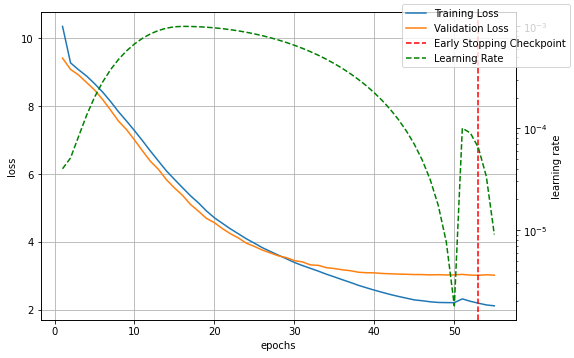

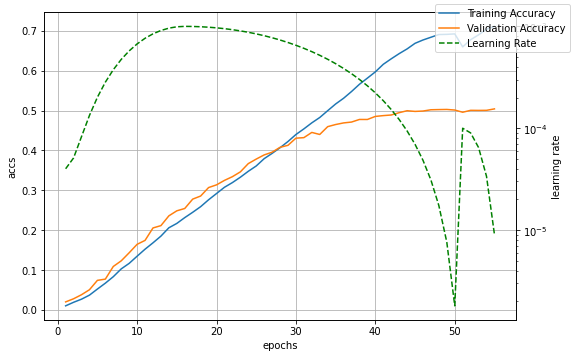

In [9]:
results = results_1 + results_2
lrs = torch.cat((lrs_1, lrs_2))
utils.plot_losses(results, lrs, train_loader, figsize=(8, 5))
utils.plot_accuracies(results, lrs, train_loader, figsize=(8, 5))